In [37]:
import numpy as np
from matplotlib import pyplot as plt 
from scipy.stats import multivariate_normal
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch
from collections import defaultdict


# Real Code

In [74]:
# User neural engine
DEVICE = "mps"

class Net(nn.Module):

    def __init__(self, num_classes=2, input_dim=2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 20)  
        self.fc2 = nn.Linear(20, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.log_softmax(self.fc2(x), dim = 1)
        x = self.fc2(x)
        return x

def test_net(net, dataset):

    criterion = nn.CrossEntropyLoss()
    net.to(DEVICE)
    net.eval()
    total_loss = total_correct = total_examples = 0
    with torch.no_grad():
        for data in dataset:
            
            X,y = data 
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            output = net(X)
            loss = criterion(output, y)
            total_loss += loss.item()
            total_correct += (output.argmax(dim=1) == y).sum().item()
            total_examples += len(y)

    return total_loss, total_correct / total_examples
            

def train_net(epochs, net, trainset, lr=0.001, to_convergence=False):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr)
    losses = []

    net.train()
    net.to(DEVICE)

    if not to_convergence:
        for epoch in range(epochs):
            #if epoch % 10 == 0:
            #    print(f"Epoch {epoch}")
            for data in trainset:
                X, y = data
                X = X.to(DEVICE)
                y = y.to(DEVICE)
                net.zero_grad()
                output = net(X)
                #loss = F.nll_loss(output, y)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
    else:
        epoch = 0
        while test_net(net, trainset)[1] < 0.99 and epoch < epochs:
            for data in trainset:
                X, y = data
                X = X.to(DEVICE)
                y = y.to(DEVICE)
                net.zero_grad()
                output = net(X)
                #loss = F.nll_loss(output, y)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
                epoch += 1

    loss, accuracy = test_net(net, trainset)
    return accuracy

    #plt.plot([i for i in range(len(losses))], losses)
    #plt.title("Training Loss")
    #plt.show()

In [18]:

num_clust_points = 100
prop = 1
mean=[0,0]
cov=[[1,0], [0,1]]
draws = np.random.multivariate_normal(mean, cov, num_clust_points)
normal_dist = multivariate_normal(mean=mean, cov=cov)
dens = normal_dist.pdf(draws)

draws_dens = []
for draw, dens in zip(draws, dens):
    draws_dens.append([draw, dens])

draws_dens.sort(key=lambda x: x[1])

sorted_draws = [x[0] for x in draws_dens]
sorted_draws[:int(prop * num_clust_points)]

[array([2.17114996, 2.09958704]),
 array([-2.32508061,  1.81453713]),
 array([ 2.27443299, -1.46079176]),
 array([-2.67270343, -0.01258056]),
 array([0.15098298, 2.63639881]),
 array([ 2.2664519 , -1.01332506]),
 array([-0.23901137,  2.44697716]),
 array([ 2.12719495, -0.79624331]),
 array([2.17245586, 0.54505639]),
 array([-2.15658669,  0.57751116]),
 array([-0.60338223,  2.14338269]),
 array([-1.91889738, -1.01123578]),
 array([1.74433114, 1.28672363]),
 array([-0.29713468,  2.13903389]),
 array([-0.14605566,  2.07480082]),
 array([1.86566964, 0.83412357]),
 array([-1.49076694,  1.33606645]),
 array([0.62816122, 1.79544945]),
 array([ 0.96222369, -1.61645357]),
 array([-1.6931614 ,  0.79705923]),
 array([ 1.03663397, -1.5297499 ]),
 array([1.53959489, 0.98702668]),
 array([-1.78600896, -0.09628318]),
 array([-0.89861103, -1.48189231]),
 array([-0.96258299, -1.40381623]),
 array([ 0.88353584, -1.44269528]),
 array([0.26571479, 1.66446917]),
 array([-0.61462069,  1.46873522]),
 array([

In [43]:

def sample_from_gaussian(num_clust_points, props = [1], mean=[0,0], cov=[[1,0], [0,1]], plot=False):

    draws = np.random.multivariate_normal(mean, cov, num_clust_points)
    normal_dist = multivariate_normal(mean=mean, cov=cov)
    dens = normal_dist.pdf(draws)

    draws_dens = []
    for draw, dens in zip(draws, dens):
        draws_dens.append([draw, dens])

    draws_dens.sort(key=lambda x: x[1])

    sorted_draws = [x[0] for x in draws_dens]
    boundary_points = [
        sorted_draws[:int(prop * num_clust_points)]
        for prop in props
    ]

    if plot:
        for bp in boundary_points:
            print(f"Number of boundary points = {len(bp)}")
            x = [draw[0] for draw in bp]
            y = [draw[1] for draw in bp]
            plt.plot(x, y, '.')
            plt.axis('equal')
            plt.show()

    return boundary_points


def get_boundary(prob = 0.01, mean=[0,0], cov=[[1,0], [0,1]]):
    boundary_points = []
    normal_dist = multivariate_normal(mean=mean, cov=cov)

    # Fill boundary points
    while len(boundary_points) < 1000:
        draws = np.random.multivariate_normal(mean, cov, 10)
        draw_dens = normal_dist.cdf(draws)

        for draw, dens in zip(draws, draw_dens):
            if dens <= prob:
                boundary_points.append(draw)

    x = [draw[0] for draw in boundary_points]
    y = [draw[1] for draw in boundary_points]

    plt.plot(x, y, '.')
    plt.axis('equal')

    return boundary_points

def get_boundary_by_prob(prob=0.01, mean=[0,0], cov=[[1,0], [0,1]], num_clust_points=10000, plot=False):

    all_points = []
    normal_dist = multivariate_normal(mean=mean, cov=cov)

    # Fill boundary points
    boundary_points = []
    while len(boundary_points) < num_clust_points:
        draws = np.random.multivariate_normal(mean, cov, 1000)
        draw_dens = normal_dist.pdf(draws)
        for draw, dens in zip(draws, draw_dens):
            if len(boundary_points) >= num_clust_points:
                break
            all_points.append(draw)
            if dens <= prob:
                boundary_points.append(draw)

    if plot:
        x = [draw[0] for draw in boundary_points]
        y = [draw[1] for draw in boundary_points]
        plt.plot(x, y, '.')
        plt.axis('equal')
    return boundary_points, all_points

def get_dataloader_from_dataset(data, classes, batch_size=4):

    assert(len(data) == len(classes))
    dataset = []

    for boundary, class_ in zip(data, classes):
        for x in boundary:
            dataset.append([x.astype('float32'), class_])

    return DataLoader(dataset, batch_size=batch_size, shuffle=True) 

def get_default_normal_params(dim=2, class_=0):
    cov = np.identity(dim)
    tmp = cov[0]
    if class_ == 0:
        # position left of origin 
        mean = tmp * -3
    elif class_ == 1:
        mean = tmp * 3
    else:
        raise ValueError("class_ argument invalid")
    
    return mean, cov


Number of boundary points = 1000


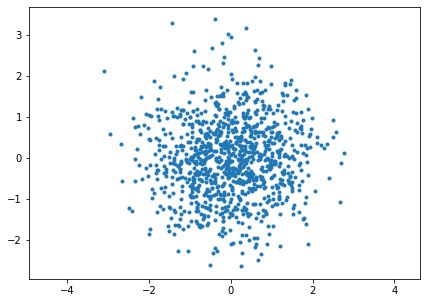

Number of boundary points = 500


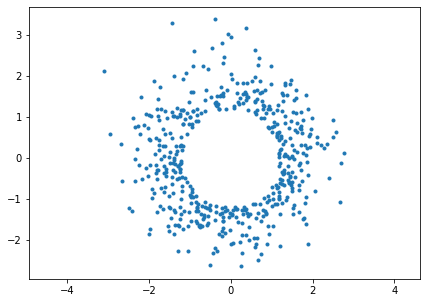

Number of boundary points = 100


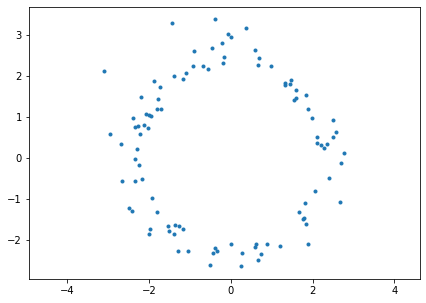

In [44]:
bp = sample_from_gaussian(num_clust_points=1000, props = [], mean=[0,0], cov=[[1,0], [0,1]], plot=True)
plt.show()


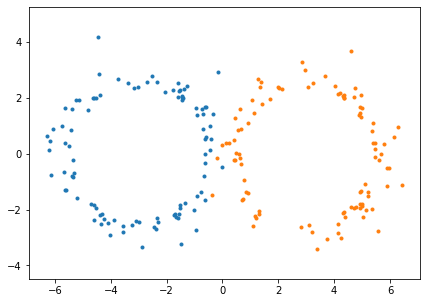

In [35]:

X_1_mean, X_1_cov = get_default_normal_params(2, 0)
X_2_mean, X_2_cov = get_default_normal_params(2, 1) 

bound_X_1, full_X_1 = get_boundary_by_prob(prob=0.01, mean=X_1_mean, cov=X_1_cov, num_clust_points=100, plot=True)
bound_X_2, full_X_2 = get_boundary_by_prob(prob=0.01, mean=X_2_mean, cov=X_2_cov, num_clust_points=100, plot=True)

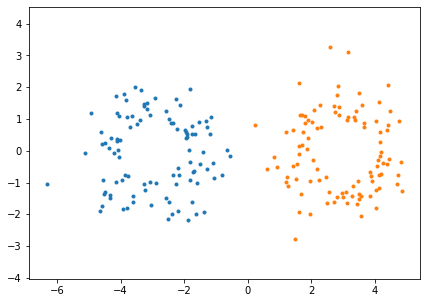

In [34]:

X_1_mean, X_1_cov = get_default_normal_params(2, 0)
X_2_mean, X_2_cov = get_default_normal_params(2, 1) 

bound_X_1, full_X_1 = get_boundary_by_prob(prob=0.1, mean=X_1_mean, cov=X_1_cov, num_clust_points=100, plot=True)
bound_X_2, full_X_2 = get_boundary_by_prob(prob=0.1, mean=X_2_mean, cov=X_2_cov, num_clust_points=100, plot=True)

In [38]:
# Full experiment code

"""
experiment_1 - concerns keep number of points in the dataset the same 
"""
X_1_MEAN = [3,0]
X_1_COV = [[1,0], [0,1]] 
X_2_MEAN = [-3,0]
X_2_COV = [[1,0], [0,1]] 
X_3_MEAN = [0,3]
X_3_COV = [[1,0], [0,1]]

MEANS = [X_1_MEAN, X_2_MEAN, X_3_MEAN]
COVS = [X_1_COV, X_2_COV, X_3_COV]

CLASSES = [0,1]
BATCH_SIZE = 128
EPOCHS = 30

def experiment_1(
    n_vals = list(range(100, 10**3, 100)),
    probs = [0.01, 0.1, 0.2, 0.5, 1],
    clusters = 2,
    plot_dec_boundary = False,
):

    experiment_driver(n_vals, probs, plot_dec_boundary)

def experiment_vary_dim_size(
    n_val,
    probs,
    plot_dec_boundary = False,
    num_reps = 1,
    dims = [2]
):

    # Loop through each prob, and each N. For each prob we create a curve
    #   of loss against N
    for prob in probs:
        print(f"P = {prob}")
        loss_vals = []
        mean_accs = []
        lower_accs = []
        upper_accs = []
        for dim in dims:
            print(f"dim = {dim}")
            model_accs = []
            # Get data
            X_1_mean, X_1_cov = get_default_normal_params(dim, 0)
            X_2_mean, X_2_cov = get_default_normal_params(dim, 1) 

            bound_X_1, full_X_1 = get_boundary_by_prob(prob=prob, mean=X_1_mean, cov=X_1_cov, num_clust_points=n_val)
            bound_X_2, full_X_2 = get_boundary_by_prob(prob=prob, mean=X_2_mean, cov=X_2_cov, num_clust_points=n_val)

            test_X_1, _ = get_boundary_by_prob(prob=1, mean=X_1_mean, cov=X_1_cov, num_clust_points=5000)
            test_X_2, _ = get_boundary_by_prob(prob=1, mean=X_2_mean, cov=X_2_cov, num_clust_points=5000)

            test_data = []
            for x in test_X_1:
                test_data.append([*x, 0])
            for x in test_X_2:
                test_data.append([*x, 1])
            test_data = np.array(test_data)
            test_labels = test_data[:,2]
            
            bound_data = []
            for x in bound_X_1:
                bound_data.append([*x, 0])
            for x in bound_X_2:
                bound_data.append([*x, 1])
            bound_data = np.array(bound_data)
            bound_labels = bound_data[:,2]

            # For model training
            if len(bound_data) <= 500:
                batch_size = 64
                epochs = 30
            else:
                batch_size = 64
                epochs = 20

            # Convert to dataloaders
            boundary_dataloader = get_dataloader_from_dataset(
                [bound_X_1, bound_X_2], 
                CLASSES,
                batch_size=batch_size
            )
            full_dataloader = get_dataloader_from_dataset(
                [full_X_1, full_X_2], 
                CLASSES,
                batch_size=batch_size
            )
            test_dataloader = get_dataloader_from_dataset(
                [test_X_1, test_X_2], 
                CLASSES,
                batch_size=batch_size
            )

            for _ in range(num_reps): 
                
                # Create and train net
                net = Net(input_dim=dim)
                train_net(epochs, net, boundary_dataloader)

                # Test net
                loss, acc = test_net(net, test_dataloader)
                loss_vals.append(loss)
                model_accs.append(acc)

                if acc < 0.8 and plot_dec_boundary:
                    #print(f"Accuracy = {acc}, N = {len(full_data)}, p = {prob}")
                    plot_decision_boundary(
                        test_dataloader, 
                        test_labels, 
                        bound_data,
                        bound_labels,
                        net
                    )

            # Collate data about num_rep models trained 
            if num_reps < 3: 
                lower_accs.append(min(model_accs))
                upper_accs.append(max(model_accs))
                mean_accs.append(np.mean(model_accs))
            else:
                model_accs = sorted(model_accs)
                model_accs.pop(0)
                model_accs.pop(-1)
                lower_accs.append(model_accs[0])
                upper_accs.append(model_accs[-1])
                mean_accs.append(np.mean(model_accs))
        
        print(f"Accuracy = {acc}, N = {n_val}, p = {prob}")
        plt.plot(dims, mean_accs, label=f"p = {prob}") 
        plt.fill_between(dims, lower_accs, upper_accs, alpha=0.2)
    
    plt.title("Accuracy of models across boundary cutoff values")
    plt.legend()
    plt.xlabel("dims")
    plt.ylabel("Accuracy")
    plt.show()

def experiment_driver(
    n_vals,
    probs,
    plot_dec_boundary = False,
    num_reps = 1,
    dim = 2
):

    # Loop through each prob, and each N. For each prob we create a curve
    #   of loss against N
    for prob in probs:
        print(f"P = {prob}")
        loss_vals = []
        mean_accs = []
        lower_accs = []
        upper_accs = []
        for n in n_vals:
            model_accs = []
            # Get data
            X_1_mean, X_1_cov = get_default_normal_params(dim, 0)
            X_2_mean, X_2_cov = get_default_normal_params(dim, 1) 

            bound_X_1, full_X_1 = get_boundary_by_prob(prob=prob, mean=X_1_mean, cov=X_1_cov, num_clust_points=n)
            bound_X_2, full_X_2 = get_boundary_by_prob(prob=prob, mean=X_2_mean, cov=X_2_cov, num_clust_points=n)

            test_X_1, _ = get_boundary_by_prob(prob=1, mean=X_1_mean, cov=X_1_cov, num_clust_points=5000)
            test_X_2, _ = get_boundary_by_prob(prob=1, mean=X_2_mean, cov=X_2_cov, num_clust_points=5000)

            test_data = []
            for x in test_X_1:
                test_data.append([*x, 0])
            for x in test_X_2:
                test_data.append([*x, 1])
            test_data = np.array(test_data)
            test_labels = test_data[:,2]
            
            bound_data = []
            for x in bound_X_1:
                bound_data.append([*x, 0])
            for x in bound_X_2:
                bound_data.append([*x, 1])
            bound_data = np.array(bound_data)
            bound_labels = bound_data[:,2]

            # For model training
            if len(bound_data) <= 500:
                batch_size = 64
                epochs = 30
            else:
                batch_size = 64
                epochs = 20

            # Convert to dataloaders
            boundary_dataloader = get_dataloader_from_dataset(
                [bound_X_1, bound_X_2], 
                CLASSES,
                batch_size=batch_size
            )
            full_dataloader = get_dataloader_from_dataset(
                [full_X_1, full_X_2], 
                CLASSES,
                batch_size=batch_size
            )
            test_dataloader = get_dataloader_from_dataset(
                [test_X_1, test_X_2], 
                CLASSES,
                batch_size=batch_size
            )
            for _ in range(num_reps): 
                
                # Create and train net
                net = Net(input_dim=dim)
                train_net(epochs, net, boundary_dataloader)

                # Test net
                loss, acc = test_net(net, test_dataloader)
                loss_vals.append(loss)
                model_accs.append(acc)

                if acc < 0.8 and plot_dec_boundary:
                    #print(f"Accuracy = {acc}, N = {len(full_data)}, p = {prob}")
                    plot_decision_boundary(
                        test_dataloader, 
                        test_labels, 
                        bound_data,
                        bound_labels,
                        net
                    )

            # Collate data about num_rep models trained 
            if num_reps < 3: 
                lower_accs.append(min(model_accs))
                upper_accs.append(max(model_accs))
                mean_accs.append(np.mean(model_accs))
            else:
                model_accs = sorted(model_accs)
                model_accs.pop(0)
                model_accs.pop(-1)
                lower_accs.append(model_accs[0])
                upper_accs.append(model_accs[-1])
                mean_accs.append(np.mean(model_accs))
        
        print(f"Accuracy = {acc}, N = {n}, p = {prob}")
        plt.plot(n_vals, mean_accs, label=f"p = {prob}") 
        plt.fill_between(n_vals, lower_accs, upper_accs, alpha=0.2)
    
    plt.title("Accuracy of models across boundary cutoff values")
    plt.legend()
    plt.xlabel("n")
    plt.ylabel("Accuracy")
    plt.show()

#def plot_decision_boundary(dataset, labels, model, steps=1000, color_map='Paired'):
def plot_decision_boundary(train_dataset, train_labels, test_dataset, test_labels, model, steps=1000, color_map='Paired'):
    model.to("cpu")
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits

    #xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    #ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    xmin, xmax =  -7, 7 
    ymin, ymax =  -4, 4
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    model.eval()
    labels_predicted = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))

    labels_predicted = np.argmax(labels_predicted.detach().numpy(), axis=1)
    #print(labels_predicted)
    # Plot decision boundary in region of interest
    labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted]
    z = np.array(labels_predicted).reshape(xx.shape)
    
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)
    # Get predicted labels on training data and plot
    train_labels_predicted = model(torch.tensor(train_dataset[:,:2], dtype=torch.float32))
    ax.scatter(train_dataset[:, 0], train_dataset[:, 1], c=train_labels.reshape(train_labels.shape[0]), cmap=color_map, lw=0, marker='.')
    plt.show()

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)
    # Get predicted labels on training data and plot
    train_labels_predicted = model(torch.tensor(test_dataset[:,:2], dtype=torch.float32))
    ax.scatter(test_dataset[:, 0], test_dataset[:, 1], c=test_labels.reshape(test_labels.shape[0]), cmap=color_map, lw=0, marker='.')
    plt.show()
    return fig, ax

In [83]:
def get_test_dataset(dim, batch_size):

    X_1_mean, X_1_cov = get_default_normal_params(dim, 0)
    X_2_mean, X_2_cov = get_default_normal_params(dim, 1) 
    test_X_1 = sample_from_gaussian(props=[1], mean=X_1_mean, cov=X_1_cov, num_clust_points=1000)[0]
    test_X_2 = sample_from_gaussian(props=[1], mean=X_2_mean, cov=X_2_cov, num_clust_points=1000)[0]

    test_dataloader = get_dataloader_from_dataset(
        [test_X_1, test_X_2], 
        CLASSES,
        batch_size=batch_size
    )

    return test_dataloader

def get_train_datasets(dim, props, n):

    X_1_mean, X_1_cov = get_default_normal_params(dim, 0)
    X_2_mean, X_2_cov = get_default_normal_params(dim, 1) 
    X_1s = sample_from_gaussian(props=props, mean=X_1_mean, cov=X_1_cov, num_clust_points=n)
    X_2s = sample_from_gaussian(props=props, mean=X_2_mean, cov=X_2_cov, num_clust_points=n)


    datasets = []
    for X_1, X_2 in zip(X_1s, X_2s):
        # Convert to dataloader
        n = len(X_1) + len(X_2)
        if n < 200:
            batch_size = n
        else:
            batch_size = 64 

        datasets.append(
            get_dataloader_from_dataset(
                [X_1, X_2], 
                CLASSES,
                batch_size=batch_size
            )
        )

    return datasets

def experiment_const_draw_size(
    n_vals,
    props,
    plot_dec_boundary = False,
    num_reps = 1,
    dim = 2,
    epochs=30,
):

    # Loop through each prob, and each N. For each prob we create a curve
    #   of loss against N
    test_dataset = get_test_dataset(dim, batch_size=64)


    train_accs = defaultdict(list)
    mean_accs = defaultdict(list)
    lower_accs  = defaultdict(list)
    upper_accs = defaultdict(list)
    for n in n_vals:
        print(f"n_val = {n}")
        # generate dataset 
        train_datasets = get_train_datasets(dim, props, n)
        for i in range(len(train_datasets)):
            train_dataset = train_datasets[i]
            prop = props[i]


            model_accs = []
            for _ in range(num_reps):
                # Create and train net
                sz = len(train_dataset.dataset)
                if sz < 300:
                    epochs = 100
                    to_convergence = True
                else:
                    epochs = 30
                    to_convergence = False

                net = Net(input_dim=dim)
                acc = train_net(epochs, net, train_dataset, to_convergence=False)
                train_accs[n,prop].append(acc)

                # Test net
                loss, acc = test_net(net, test_dataset)
                model_accs.append(acc)

            # Collate data about num_rep models trained 
            if num_reps < 3: 
                lower_accs[prop].append(min(model_accs))
                upper_accs[prop].append(max(model_accs))
                mean_accs[prop].append(np.mean(model_accs))
            else:
                model_accs = sorted(model_accs)
                model_accs.pop(0)
                model_accs.pop(-1)
                lower_accs[prop].append(model_accs[0])
                upper_accs[prop].append(model_accs[-1])
                mean_accs[prop].append(np.mean(model_accs))

    # Plot results 
    for prop in props:

        plt.plot(n_vals, mean_accs[prop], label=f"{prop}") 
        plt.fill_between(n_vals, lower_accs[prop], upper_accs[prop], alpha=0.2)
    
    plt.title("Accuracy of models across boundary cutoff values")
    plt.legend(title="Proportion Of Dataset")
    plt.xlabel("Drawn Dataset Size")
    plt.ylabel("Accuracy")
    plt.show()

    return train_accs

In [92]:
def print_failed_trains(train_accs):
    for config, train_acc in train_accs.items():
        for acc in train_acc:
            if acc != 1:
                print(f"{config}\t{train_acc}")

n_val = 1000
n_val = 1200
n_val = 1400
n_val = 1600
n_val = 1800
n_val = 2000


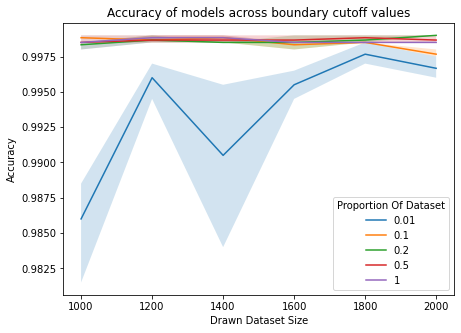

(1000, 0.01)	[0.95, 0.85, 0.95, 0.95, 0.95]
(1000, 0.01)	[0.95, 0.85, 0.95, 0.95, 0.95]
(1000, 0.01)	[0.95, 0.85, 0.95, 0.95, 0.95]
(1000, 0.01)	[0.95, 0.85, 0.95, 0.95, 0.95]
(1000, 0.01)	[0.95, 0.85, 0.95, 0.95, 0.95]
(1000, 0.1)	[0.975, 0.98, 0.975, 0.975, 0.98]
(1000, 0.1)	[0.975, 0.98, 0.975, 0.975, 0.98]
(1000, 0.1)	[0.975, 0.98, 0.975, 0.975, 0.98]
(1000, 0.1)	[0.975, 0.98, 0.975, 0.975, 0.98]
(1000, 0.1)	[0.975, 0.98, 0.975, 0.975, 0.98]
(1000, 0.2)	[0.9875, 0.99, 0.99, 0.9875, 0.9875]
(1000, 0.2)	[0.9875, 0.99, 0.99, 0.9875, 0.9875]
(1000, 0.2)	[0.9875, 0.99, 0.99, 0.9875, 0.9875]
(1000, 0.2)	[0.9875, 0.99, 0.99, 0.9875, 0.9875]
(1000, 0.2)	[0.9875, 0.99, 0.99, 0.9875, 0.9875]
(1000, 0.5)	[0.995, 0.995, 0.995, 0.996, 0.995]
(1000, 0.5)	[0.995, 0.995, 0.995, 0.996, 0.995]
(1000, 0.5)	[0.995, 0.995, 0.995, 0.996, 0.995]
(1000, 0.5)	[0.995, 0.995, 0.995, 0.996, 0.995]
(1000, 0.5)	[0.995, 0.995, 0.995, 0.996, 0.995]
(1000, 1)	[0.9975, 0.9985, 0.9975, 0.998, 0.998]
(1000, 1)	[0.997

In [93]:
plt.rcParams["figure.figsize"] = (7,5)
n_vals = list(range(1000, 2200, 200))
props = [0.01, 0.1, 0.2, 0.5, 1]
clusters = 2
#plot_dec_boundary = False,

train_accs = experiment_const_draw_size(n_vals, props, plot_dec_boundary = False, num_reps = 5, dim=2)
print_failed_trains(train_accs)

n_val = 1000
n_val = 1200
n_val = 1400
n_val = 1600
n_val = 1800
n_val = 2000


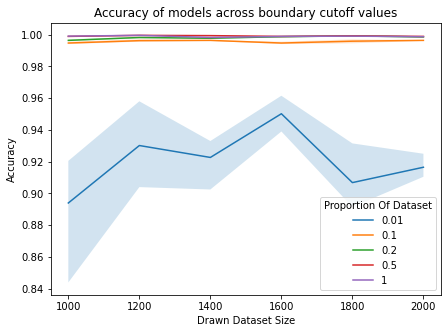

(1000, 0.2)	[0.9975, 0.9975, 0.9975, 0.995, 0.995]
(1000, 0.2)	[0.9975, 0.9975, 0.9975, 0.995, 0.995]
(1000, 0.2)	[0.9975, 0.9975, 0.9975, 0.995, 0.995]
(1000, 0.2)	[0.9975, 0.9975, 0.9975, 0.995, 0.995]
(1000, 0.2)	[0.9975, 0.9975, 0.9975, 0.995, 0.995]
(1000, 0.5)	[0.999, 1.0, 1.0, 0.999, 1.0]
(1000, 0.5)	[0.999, 1.0, 1.0, 0.999, 1.0]
(1200, 0.2)	[0.9958333333333333, 0.9979166666666667, 0.99375, 0.9958333333333333, 0.99375]
(1200, 0.2)	[0.9958333333333333, 0.9979166666666667, 0.99375, 0.9958333333333333, 0.99375]
(1200, 0.2)	[0.9958333333333333, 0.9979166666666667, 0.99375, 0.9958333333333333, 0.99375]
(1200, 0.2)	[0.9958333333333333, 0.9979166666666667, 0.99375, 0.9958333333333333, 0.99375]
(1200, 0.2)	[0.9958333333333333, 0.9979166666666667, 0.99375, 0.9958333333333333, 0.99375]
(1200, 0.5)	[0.9991666666666666, 1.0, 0.9991666666666666, 1.0, 0.9983333333333333]
(1200, 0.5)	[0.9991666666666666, 1.0, 0.9991666666666666, 1.0, 0.9983333333333333]
(1200, 0.5)	[0.9991666666666666, 1.0, 0.

In [94]:
n_vals = list(range(1000, 2200, 200)) 
props = [0.01, 0.1, 0.2, 0.5, 1]
clusters = 2
#plot_dec_boundary = False,

train_accs = experiment_const_draw_size(n_vals, props, plot_dec_boundary = False, num_reps = 5, dim=20)
print_failed_trains(train_accs)

n_val = 1000
n_val = 1200
n_val = 1400
n_val = 1600
n_val = 1800
n_val = 2000


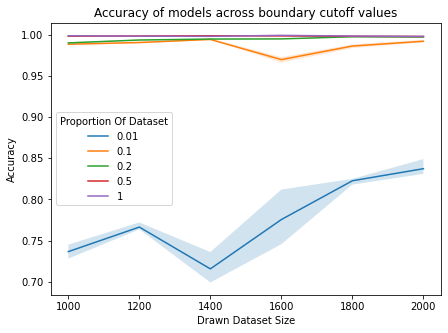

(1000, 0.2)	[1.0, 0.995, 0.9975, 1.0, 0.9975]
(1000, 0.2)	[1.0, 0.995, 0.9975, 1.0, 0.9975]
(1000, 0.2)	[1.0, 0.995, 0.9975, 1.0, 0.9975]
(1200, 0.2)	[1.0, 1.0, 0.9979166666666667, 1.0, 1.0]
(1400, 0.5)	[0.9992857142857143, 1.0, 0.9992857142857143, 0.9992857142857143, 1.0]
(1400, 0.5)	[0.9992857142857143, 1.0, 0.9992857142857143, 0.9992857142857143, 1.0]
(1400, 0.5)	[0.9992857142857143, 1.0, 0.9992857142857143, 0.9992857142857143, 1.0]
(1600, 0.1)	[0.99375, 1.0, 0.996875, 1.0, 0.99375]
(1600, 0.1)	[0.99375, 1.0, 0.996875, 1.0, 0.99375]
(1600, 0.1)	[0.99375, 1.0, 0.996875, 1.0, 0.99375]
(1800, 0.1)	[0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 1.0]
(1800, 0.1)	[0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 1.0]
(1800, 0.1)	[0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 1.0]
(1800, 0.1)	[0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 1.0]
(1800, 0.2)	[1.

In [95]:
n_vals = list(range(1000, 2200, 200)) 
props = [0.01, 0.1, 0.2, 0.5, 1]
clusters = 2
#plot_dec_boundary = False,

train_accs = experiment_const_draw_size(n_vals, props, plot_dec_boundary = False, num_reps = 5, dim=50)
print_failed_trains(train_accs)

n_val = 1000
n_val = 1200
n_val = 1400
n_val = 1600
n_val = 1800
n_val = 2000


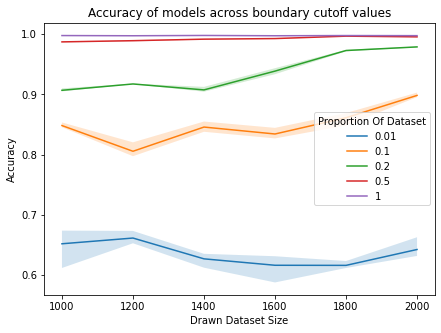

In [96]:

n_vals = list(range(1000, 2200, 200)) 
props = [0.01, 0.1, 0.2, 0.5, 1]
clusters = 2
#plot_dec_boundary = False,

train_accs = experiment_const_draw_size(n_vals, props, plot_dec_boundary = False, num_reps = 5, dim=200)
print_failed_trains(train_accs)

n_val = 1000
n_val = 1200
n_val = 1400
n_val = 1600
n_val = 1800
n_val = 2000


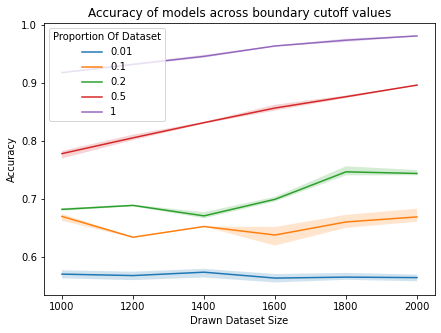

(1200, 0.2)	[1.0, 1.0, 1.0, 1.0, 0.9979166666666667]
(1600, 0.5)	[0.999375, 1.0, 1.0, 1.0, 1.0]
(2000, 0.2)	[1.0, 1.0, 1.0, 1.0, 0.99875]


In [91]:
n_vals = list(range(1000, 2200, 200)) 
props = [0.01, 0.1, 0.2, 0.5, 1]
clusters = 2
#plot_dec_boundary = False,

train_accs = experiment_const_draw_size(n_vals, props, plot_dec_boundary = False, num_reps = 5, dim=1000)
print_failed_trains(train_accs)

In [90]:
def print_failed_trains(train_accs):
    for config, train_acc in train_accs.items():
        for acc in train_acc:
            if acc != 1:
                print(f"{config}\t{train_acc}")

In [6]:
plt.rcParams["figure.figsize"] = (7,5)
n_vals = list(range(200, 1000, 100))
probs = [0.01, 0.05, 0.1, 0.5, 1]
clusters = 2
#plot_dec_boundary = False,
experiment_driver(n_vals, probs, plot_dec_boundary = False, num_reps = 5, 2)

SyntaxError: positional argument follows keyword argument (392312543.py, line 6)

P = 0.01
Accuracy = 0.9983487450462352, N = 900, p = 0.01
P = 0.05
Accuracy = 0.9979539641943734, N = 900, p = 0.05
P = 0.1
Accuracy = 0.9966666666666667, N = 900, p = 0.1
P = 0.5
Accuracy = 0.9994444444444445, N = 900, p = 0.5
P = 1
Accuracy = 0.9977777777777778, N = 900, p = 1


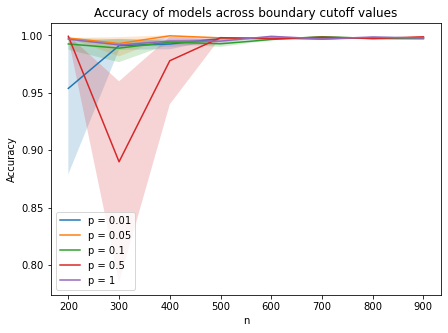

In [7]:
plt.rcParams["figure.figsize"] = (7,5)
n_vals = list(range(200, 1000, 100))
probs = [0.01, 0.05, 0.1, 0.5, 1]
clusters = 2
#plot_dec_boundary = False,
experiment_driver(n_vals, probs, plot_dec_boundary = False, num_reps = 5, dim=2)

P = 0.01
Accuracy = 0.9981, N = 900, p = 0.01
P = 0.05
Accuracy = 0.9975, N = 900, p = 0.05
P = 0.1
Accuracy = 0.998, N = 900, p = 0.1
P = 0.5
Accuracy = 0.997, N = 900, p = 0.5
P = 1
Accuracy = 0.9979, N = 900, p = 1


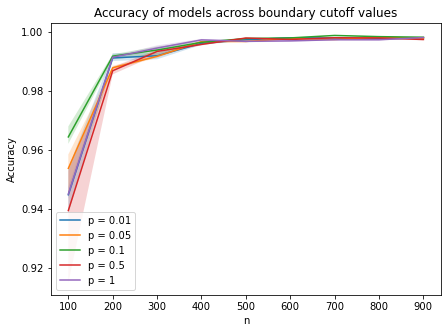

In [53]:
plt.rcParams["figure.figsize"] = (7,5)
n_vals = list(range(100, 1000, 100))
probs = [0.01, 0.05, 0.1, 0.5, 1]
clusters = 2
#plot_dec_boundary = False,
experiment_driver(n_vals, probs, plot_dec_boundary = False, num_reps = 5, dim=50)

P = 0.001
dim = 100
dim = 200
dim = 300
dim = 400
dim = 500
dim = 1000
Accuracy = 0.9966, N = 5000, p = 0.001
P = 0.005
dim = 100
dim = 200
dim = 300
dim = 400
dim = 500
dim = 1000
Accuracy = 0.9957, N = 5000, p = 0.005
P = 0.01
dim = 100
dim = 200
dim = 300
dim = 400
dim = 500
dim = 1000
Accuracy = 0.9955, N = 5000, p = 0.01


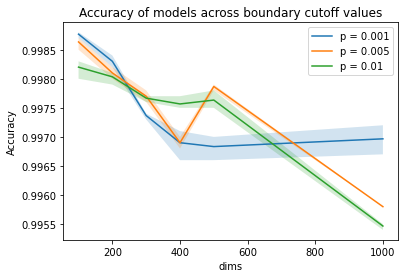

In [14]:
experiment_vary_dim_size(
    n_val=5000,
    probs=[0.001, 0.005, 0.01],
    plot_dec_boundary = False,
    num_reps = 5,
    dims = [100,200,300,400,500,1000]
)

P = 0.01
Accuracy = 0.794, N = 1000, p = 0.01


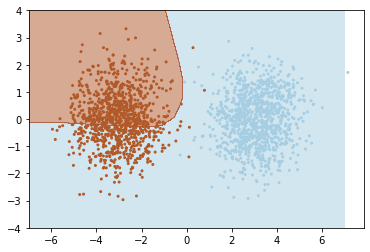

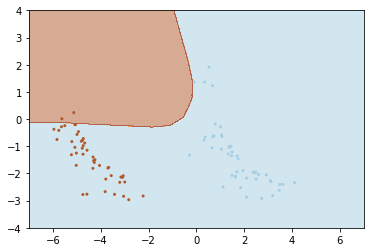

Accuracy = 0.9931313131313131, N = 9900, p = 0.01


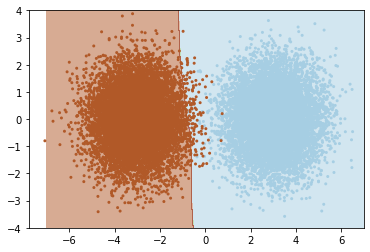

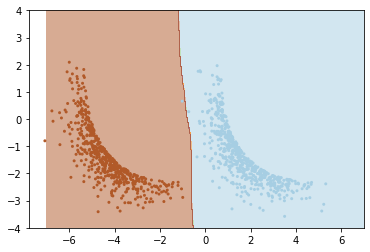

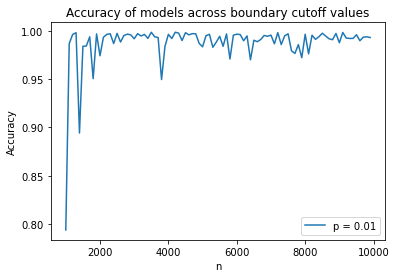

In [6]:
experiment_1(probs = [0.01], n_vals = list(range(10**3, 10**4, 100)), plot_dec_boundary=True)

In [19]:
experiment_1(probs = [0.01,0.1], n_vals = list(range(10**3, 10**4, 100)))

P = 0.01


KeyboardInterrupt: 

P = 0.01
P = 0.1
P = 0.5
P = 1


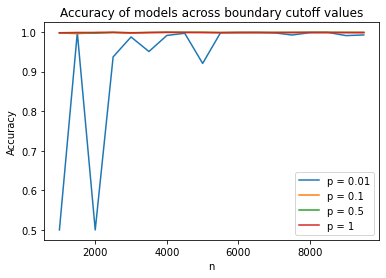

In [13]:
experiment_1(probs = [0.01,0.1, 0.5, 1], n_vals = list(range(10**3, 10**4, 500)))

P = 0.01
P = 0.1
P = 0.5
P = 1


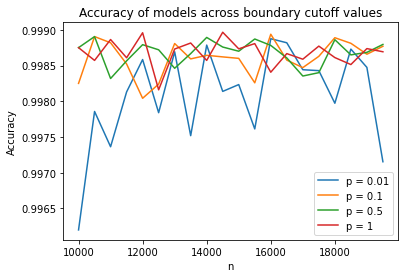

In [41]:
#n = [10**4 + 10**3 * i  for i in range(10)]
n = list(range(10**4, 10**4 * 2, 500))
experiment_1(probs = [0.01,0.1, 0.5, 1], n_vals = n)

P = 0.01
P = 0.1
P = 0.5
P = 1


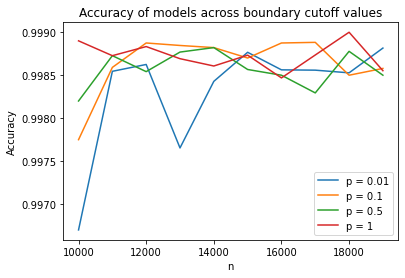

In [14]:
n = [10**4 + 10**3 * i  for i in range(10)]
experiment_1(probs = [0.01,0.1, 0.5, 1], n_vals = n)

P = 0.01
P = 0.1
P = 0.5
P = 1


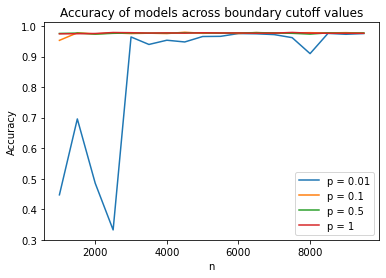

In [24]:
experiment_2(probs = [0.01,0.1, 0.5, 1], n_vals = list(range(10**3, 10**4, 500)), clusters=3)

P = 0.01
P = 0.02
P = 0.05
P = 0.08


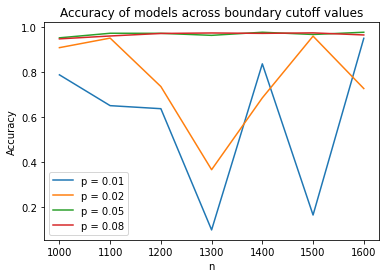

In [26]:
experiment_2(probs = [0.01,0.02, 0.05, 0.08], n_vals = list(range(10**3, 10**3 + 601, 100)), clusters=3)

P = 0.01
P = 0.02
P = 0.05
P = 0.08


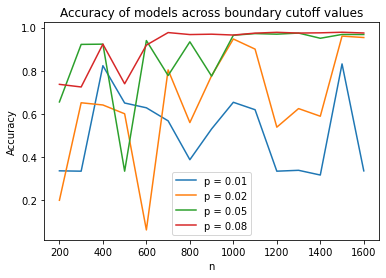

In [30]:
experiment_2(probs = [0.01,0.02, 0.05, 0.08], n_vals = list(range(200, 10**3 + 601, 100)), clusters=3)

P = 0.01
P = 0.02
P = 0.05
P = 0.08


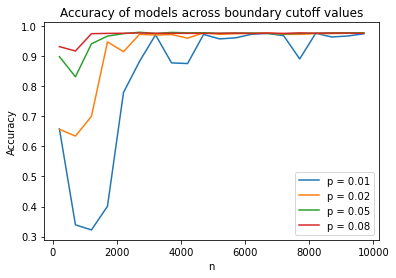

In [32]:
experiment_2(probs = [0.01,0.02, 0.05, 0.08], n_vals = list(range(200, 10**4, 500)), clusters=3)


P = 0.01
P = 0.02
P = 0.05
P = 0.08


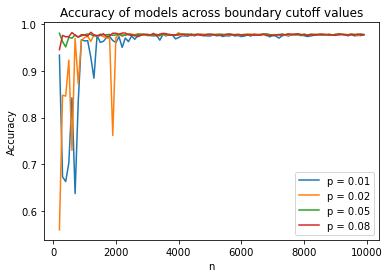

In [20]:
experiment_2(probs = [0.01,0.02, 0.05, 0.08], n_vals = list(range(200, 10**4, 100)), clusters=3)

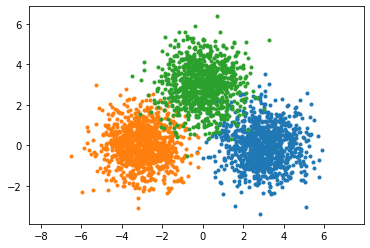

In [46]:
for i in range(3):
    mn = MEANS[i]
    cv = COVS[i]
    bound, full = get_boundary_by_prob(prob=1, mean=mn, cov=cv, num_clust_points=1000, plot=True)

#def get_boundary_by_prob(prob = 0.01, mean=[0,0], cov=[[1,0], [0,1]], num_clust_points=10000, plot=False):
plt.show()

0.06166666666666667
0.057666666666666665


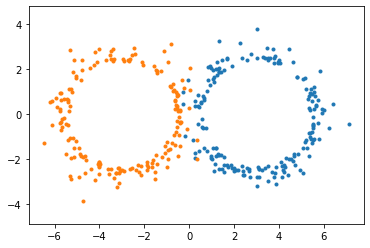

In [51]:
for i in range(2):
    mn = MEANS[i]
    cv = COVS[i]
    bound, full = get_boundary_by_prob(prob=0.01, mean=mn, cov=cv, num_clust_points=3000, plot=True)

    print(len(bound) / len(full))


#def get_boundary_by_prob(prob = 0.01, mean=[0,0], cov=[[1,0], [0,1]], num_clust_points=10000, plot=False):
plt.show()

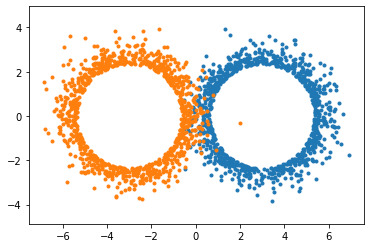

In [94]:
X_1 = get_boundary(prob = 0.01, mean=[3,0], cov=[[1,0], [0,1]])
X_2 = get_boundary(prob = 0.01, mean=[-3,0], cov=[[1,0], [0,1]])
#X_3 = get_boundary(prob = 0.01, mean=[-1,10], cov=[[2,0], [0,2]])
plt.show()


Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90


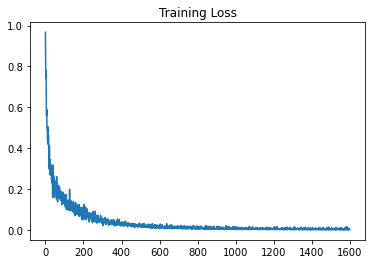

In [85]:
boundary_dataloader = get_dataloader_from_dataset([X_1, X_2], [0,1], batch_size=128)
net = Net()
train_net(100, net, boundary_dataloader)

In [80]:
for X,y in boundary_dataloader:
    with torch.no_grad():
        pred = net(X[:4,:])
        expected = y[:4]
    break


tensor([[ 6.1568, -5.9187],
        [ 6.0728, -6.7014],
        [ 5.9771, -6.8635],
        [ 6.1059, -7.0593]])
tensor([0, 0, 0, 0])
tensor(4)


In [88]:
test_net(net, boundary_dataloader)

(0.06356361205689609, 1.0)